In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

In [25]:
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal ** 2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    noisy_signal = signal + noise_r
    return noisy_signal

def bit_error_rate(y_true, y_pred):
    true = ''.join([f"{sym:04b}" for sym in np.array(y_true)])
    pred = ''.join([f"{sym:04b}" for sym in np.array(y_pred)])
    # Calculate BER (bit error rate) of the constellation (true vs pred)
    ber = sum([1 for i in range(len(true)) if true[i] != pred[i]]) / len(true)
    return ber

In [26]:
Ns = 100000
n = 16
y = np.random.randint(n, size=Ns)

In [27]:
mod_dict = {
    0: -3.+3.j, 1: -3.+1.j, 2: -3.-3.j, 3: -3.-1.j,
    4: -1.+3.j, 5: -1.+1.j, 6: -1.-3.j, 7: -1.-1.j,
    8:  3.+3.j, 9:  3.+1.j, 10: 3.-3.j, 11: 3.-1.j,
    12: 1.+3.j, 13: 1.+1.j, 14: 1.-3.j, 15: 1.-1.j
}

mod_sym = np.array([mod_dict[i] for i in y])

Xr = np.real(mod_sym)
Xi = np.imag(mod_sym)

osnr = 16

Xr_ch = add_noise(Xr, osnr)
Xi_ch = add_noise(Xi, osnr)

X = np.column_stack((Xr_ch, Xi_ch))

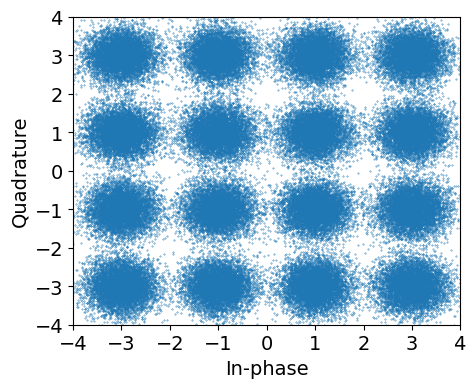

In [28]:
plt.figure(figsize=(5, 4))
plt.scatter(Xr_ch, Xi_ch, s=0.1)
plt.xlabel('In-phase', fontsize=14)
plt.ylabel('Quadrature', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [30]:
t0 = time.time()
knn = KNeighborsClassifier(n_neighbors=15).fit(X_train, y_train)

y_pred = knn.predict(X_test)
t1 = time.time()
print('KNN training time: ', (t1 - t0) * 1000, 'ms')

KNN training time:  2793.2629585266113 ms


In [31]:
t0 = time.time()
svm = SVC(kernel='rbf', C=1e3, gamma=0.1).fit(X_train, y_train)

y_pred = svm.predict(X_test)
t1 = time.time()
print('SVM training time: ', (t1 - t0) * 1000, 'ms')

SVM training time:  1807.5335025787354 ms


In [32]:
t0 = time.time()
dt = DecisionTreeClassifier().fit(X_train, y_train)

y_pred = dt.predict(X_test)
t1 = time.time()
print('Decision tree training time: ', (t1 - t0) * 1000, 'ms')

Decision tree training time:  32.06586837768555 ms


In [33]:
t0 = time.time()
rf = RandomForestClassifier(n_estimators=100, criterion='entropy').fit(X_train, y_train)

y_pred = rf.predict(X_test)
t1 = time.time()
print('Random forest training time: ', (t1 - t0) * 1000, 'ms')

Random forest training time:  4268.367052078247 ms


In [34]:
t0 = time.time()
kmeans = KMeans(n_clusters=n).fit(X_test)

y_pred = kmeans.labels_
t1 = time.time()
print('K-means training time: ', (t1 - t0) * 1000, 'ms')

c:\Users\kevin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-means training time:  1148.820161819458 ms


In [35]:
ix = np.argsort(y_test)
new_X = X_test[ix]

t0 = time.time()
dbscan = DBSCAN(eps=0.1).fit(new_X)
labels = dbscan.labels_
noise_index = np.where(labels == -1)[0]
non_noise_index = np.where(labels != -1)[0]
noise_points = new_X[noise_index]
non_noise_points = new_X[non_noise_index]

tree = cKDTree(non_noise_points)
ind = tree.query_ball_point(noise_points, r=0.5)

for it, item in enumerate(ind):
    neighbors = non_noise_index[item]
    if len(neighbors) > 0:
        new_label = np.bincount(y[neighbors]).argmax()
        labels[noise_index[it]] = new_label
    else:
        labels[noise_index[it]] = 0

y_pred = labels[ix]
t1 = time.time()
print('DBSCAN training time: ', (t1 - t0) * 1000, 'ms')

DBSCAN training time:  1479.4871807098389 ms
